# カメラ外部パラメータ推定
OpenCVを用いて、既知の内部パラメータを使い、チェスボード平面に対する外部パラメータ（姿勢）を求めます。

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

## カメラ内部パラメータとチェスボード設定

In [26]:
# 既知のキャリブレーションパラメータを読み込み
intrinsics_param_file = "./camera_calibration_result.npz"
if os.path.exists(intrinsics_param_file):
    data = np.load(intrinsics_param_file)
    K = data['K']
    dist = data['dist']
    rvecs = data['rvecs']
    tvecs = data['tvecs']
else:
    raise FileNotFoundError(f"Calibration parameters file '{intrinsics_param_file}' not found.")

# チェスボードのサイズ（交点数）
CHECKERBOARD = (35, 25)

# 世界座標系上の基準点（Z=0平面）
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

## 任意の画像からチェスボードを検出し、外部パラメータを推定

回転ベクトル rvec:
 [-0.13985809  0.72009487  2.82158954]
並進ベクトル tvec:
 [18.42709012  0.99956584 31.25401047]
回転行列 R:
 [[-0.96997968 -0.24046491 -0.03627744]
 [ 0.1936722  -0.85406171  0.4827729 ]
 [-0.14707311  0.46125397  0.87499387]]


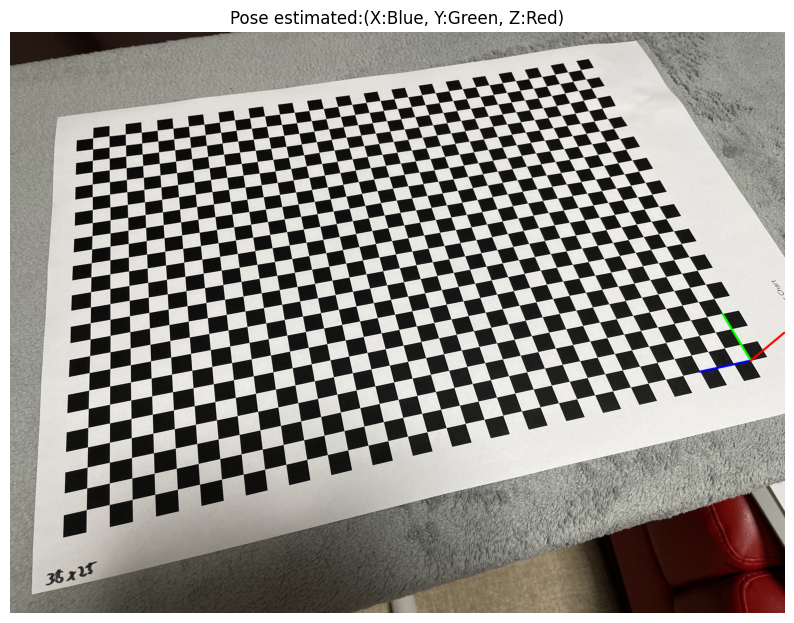

In [27]:
image_path = "./carib_test/ext_carib_images/IMG_3503.JPG"  # 対象画像を指定
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# チェスボード検出
ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)

if ret:
    corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1),
        criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

    ret, rvec, tvec = cv2.solvePnP(objp, corners2, K, dist)
    R, _ = cv2.Rodrigues(rvec)

    print("回転ベクトル rvec:\n", rvec.ravel())
    print("並進ベクトル tvec:\n", tvec.ravel())
    print("回転行列 R:\n", R)

    # 軸を描画
    axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]])
    imgpts, _ = cv2.projectPoints(axis, rvec, tvec, K, dist)
    corner = tuple(corners2[0].ravel().astype(int))
    img = cv2.line(img, corner, tuple(imgpts[0].ravel().astype(int)), (255,0,0), 9)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel().astype(int)), (0,255,0), 9)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel().astype(int)), (0,0,255), 9)

    plt.figure(figsize=(10, 8))
    plt.title("Pose estimated:(X:Blue, Y:Green, Z:Red)")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
else:
    print("チェスボード検出に失敗しました。")

In [28]:
# チェスボードの交点を10mm間隔として外部パラメータを再計算
objp *= 0.01  # 10mmスケールに変換
if ret:
    ret, rvec, tvec = cv2.solvePnP(objp, corners2, K, dist)
    R, _ = cv2.Rodrigues(rvec)

    print("10mmスケールでの回転ベクトル rvec:\n", rvec.ravel())
    print("10mmスケールでの並進ベクトル tvec:\n", tvec.ravel())
    print("10mmスケールでの回転行列 R:\n", R)
    # 軸を描画
    imgpts, _ = cv2.projectPoints(axis * 0.01, rvec, tvec, K, dist)
    corner = tuple(corners2[0].ravel().astype(int))
    img = cv2.line(img, corner, tuple(imgpts[0].ravel().astype(int)), (255,0,0), 9)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel().astype(int)), (0,255,0), 9)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel().astype(int)), (0,0,255), 9)


10mmスケールでの回転ベクトル rvec:
 [-0.13985808  0.72009486  2.82158954]
10mmスケールでの並進ベクトル tvec:
 [0.1842709  0.00999566 0.3125401 ]
10mmスケールでの回転行列 R:
 [[-0.96997968 -0.2404649  -0.03627744]
 [ 0.19367221 -0.85406171  0.48277289]
 [-0.14707311  0.46125396  0.87499388]]


Point 1 in 3D space: [-7.3023117e+08 -2.3947306e+08]
Point 2 in 3D space: [-8.2939074e+12 -1.1616721e+12]


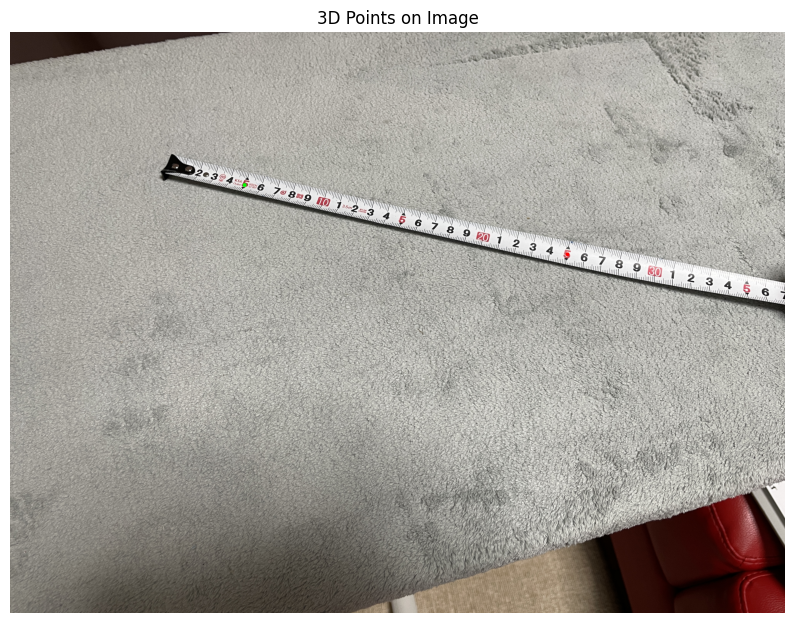

In [ ]:
# 画像を読み込み
range_inspect_test_image = cv2.imread("carib_test/measure_test_images/IMG_3504.JPG")
if range_inspect_test_image is None:
    raise FileNotFoundError("指定された画像が見つかりません。パスを確認してください。")
# 画像をグレースケールに変換
gray = cv2.cvtColor(range_inspect_test_image, cv2.COLOR_BGR2GRAY)
# 1220,800 と 2900,1160の座標を指定
point1 = (1220, 800)
point2 = (2900, 1160)
# 計算したカメラの外部パラメータを使用して、3D空間上の点を計算
if ret:
    # 画像上の点をfloat32型で3D空間に変換
    point1_3d, _ = cv2.projectPoints(np.array([[point1[0], point1[1], 0]], dtype=np.float32), rvec, tvec, K, dist)
    point2_3d, _ = cv2.projectPoints(np.array([[point2[0], point2[1], 0]], dtype=np.float32), rvec, tvec, K, dist)

    # 2点間の距離を計算
    distance = np.linalg.norm(point1_3d - point2_3d)
    print(f"Distance between points in 3D space: {distance.ravel()[0]} meters")

    # 3D空間上の点を表示
    print(f"Point 1 in 3D space: {point1_3d.ravel()}")
    print(f"Point 2 in 3D space: {point2_3d.ravel()}")
    # 画像上に点を描画
    cv2.circle(range_inspect_test_image, point1, 10, (0, 255, 0), -1)  # 緑色の点
    cv2.circle(range_inspect_test_image, point2, 10, (0, 0, 255), -1)  # 青色の点
    # 画像を表示
    plt.figure(figsize=(10, 8))
    plt.title("3D Points on Image")
    plt.imshow(cv2.cvtColor(range_inspect_test_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
else:
    print("チェスボード検出に失敗しました。3D空間の点を計算できません。")